<a href="https://colab.research.google.com/github/emrapport/w266-final-project/blob/master/final_model_error_analysis_ER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Error analysis of final model



In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import time
import pickle
!pip install gcsfs

pd.set_option('max_colwidth', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# this cell is only necessary if running in colab
project_id = 'w266-251323'
import uuid
bucket_name = 'fb-congressional-data/'
from google.colab import auth
auth.authenticate_user()
!gcloud config set project {project_id}

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Updated property [core/project].


In [3]:
# Load the test data and predictions
dev_df = pd.read_csv("gs://fb-congressional-data/contraction_expanded_data/dev.csv", index_col=0)
test_df = pd.read_csv("gs://fb-congressional-data/contraction_expanded_data/test.csv", index_col=0)
dev_preds = pd.read_csv("gs://fb-congressional-data/models/dev_preds.csv")
test_preds = pd.read_csv("gs://fb-congressional-data/models/test_preds.csv")
dev_preds_party = pd.read_csv("gs://fb-congressional-data/models/dev_preds_party.csv")
test_preds_party = pd.read_csv("gs://fb-congressional-data/models/test_preds_party.csv")
test_preds_party = pd.read_csv("gs://fb-congressional-data/models/test_preds_party.csv")



/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
test_preds.head()

,original_idx,probs,preds
0,9225551,0.398534,M
1,7514285,0.363646,M
2,6128273,0.283775,M
3,6370382,0.320124,M
4,8962461,0.316799,M


In [5]:
test_preds_party.head()

,original_idx,probs_party,preds_party
0,9225551,0.384233,Congress_Republican
1,7514285,0.545365,Congress_Democrat
2,6128273,0.400835,Congress_Republican
3,6370382,0.327347,Congress_Republican
4,8962461,0.461587,Congress_Republican


In [6]:
dev_preds.head()

,original_idx,probs,preds
0,2210805,0.288363,M
1,10316428,0.253759,M
2,5297343,0.252464,M
3,5030266,0.293893,M
4,4918178,0.176300,M


In [7]:
dev_preds_party.head()


,original_idx,probs_party,preds_party
0,2210805,0.653872,Congress_Democrat
1,10316428,0.457214,Congress_Republican
2,5297343,0.353170,Congress_Republican
3,5030266,0.544343,Congress_Democrat
4,4918178,0.144020,Congress_Republican


In [0]:
# Correct the "democratic" party prediction to match op party (haven't executed this cell yet)
dev_preds_party.loc[dev_preds_party['preds_party']=='Congress_Democrat', 'preds_party'] = 'Congress_Democratic'
test_preds_party.loc[test_preds_party['preds_party']=='Congress_Democrat', 'preds_party'] = 'Congress_Democratic'


In [9]:
test_df = test_df.merge(test_preds,on='original_idx')
test_df = test_df.merge(test_preds_party,on='original_idx')
test_df.head()

,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
0,1682766,78379937,W,21367,Tonia,jacky thank you for addressing this very troubling news! please demand a full independent invest...,Jacky Rosen,Congress_Democratic,0.286659,M,0.567257,Congress_Democratic
1,1682767,78379937,W,21367,Michancy,agreed! the russian connection to this administration must be fully investigated. flynn is the ...,Jacky Rosen,Congress_Democratic,0.150482,M,0.439200,Congress_Republican
2,1682768,78379937,W,21367,Andrea,please push chaffez and cummings to look into this!,Jacky Rosen,Congress_Democratic,0.203123,M,0.508537,Congress_Democratic
3,1682769,78379937,W,21367,Tina,i could not agree more!,Jacky Rosen,Congress_Democratic,0.229004,M,0.370849,Congress_Republican
4,1682770,78379937,W,21368,Cathy,"i imagine that is followed by ""when qualifited.""",Jacky Rosen,Congress_Democratic,0.275994,M,0.354149,Congress_Republican


In [10]:
dev_df = dev_df.merge(dev_preds,on='original_idx')
dev_df = dev_df.merge(dev_preds_party,on='original_idx')
dev_df.head()

,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
0,1965080,86681682,M,29909,James,thanks for passing this ridiculous legislation. https://www.youtube.com/watch?v=-y4wd8royre,Jim Banks,Congress_Republican,0.208421,M,0.391387,Congress_Republican
1,1965081,86681682,M,29909,Martha,handsome young man on the left. 😂 mom,Jim Banks,Congress_Republican,0.257950,M,0.436190,Congress_Republican
2,1965082,86681682,M,29911,Preston,you are sideways!,Jim Banks,Congress_Republican,0.364659,M,0.484376,Congress_Republican
3,1965083,86681682,M,29911,Bobby,hi congressman banks,Jim Banks,Congress_Republican,0.035806,M,0.493345,Congress_Republican
4,1965084,86681682,M,29911,Landon,"jim, i love your office. the 5th floor is for winners.",Jim Banks,Congress_Republican,0.048077,M,0.546275,Congress_Democratic


In [0]:
wrong_preds = test_df[test_df.op_gender!=test_df.preds]


In [40]:
wrong_preds.op_gender.value_counts()

W    219299
M     36790
Name: op_gender, dtype: int64

In [41]:
# total proportion of preds for women
dev_df.preds.value_counts()['W'] / len(dev_df)

0.03995132955674003

In [42]:
#random sample of mistakes
wrong_preds.sample(10)

,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
351746,5926630,15083367,W,201389,Susan,actually federal government employees only make up 2% of the federal budget. they are well under...,Barbara Comstock,Congress_Republican,0.208,M,0.248,Congress_Republican
698084,8903560,3162230,W,304876,Jay,i voted for you as many times as they let me. :),Kristi Noem,Congress_Republican,0.386,M,0.448,Congress_Republican
70842,2332384,98470558,W,50371,Robert,disappointed in this vote.,Elise Stefanik,Congress_Republican,0.251,M,0.332,Congress_Republican
353005,5927952,15083367,W,201406,Xavier,"catering to madness who needs real leadership when the ""fake news"" turns the temporary ordered...",Barbara Comstock,Congress_Republican,0.231,M,0.524,Congress_Democratic
276370,3504664,33093506,W,114841,John,great job requesting the u.s. department of justice review walker's crony loans. maybe some othe...,Tammy Baldwin,Congress_Democratic,0.334,M,0.715,Congress_Democratic
294940,4107271,72264613,W,146673,AltheaRalph,...let us try to honor our brave men and women by paying and voting to pay them a decent wage.,Kyrsten Sinema,Congress_Democratic,0.207,M,0.345,Congress_Republican
730339,8963723,4804331,W,310238,Janet,i9 guess now you will have to highlight what you did to us with your xl and wall street votes,Cheri Bustos,Congress_Democratic,0.296,M,0.589,Congress_Democratic
317455,4131195,72264613,W,148369,David,same here,Kyrsten Sinema,Congress_Democratic,0.283,M,0.347,Congress_Republican
69853,2331357,98470558,W,50352,Andrew,i do not understand. you think our representative in congress has no obligation to hear from co...,Elise Stefanik,Congress_Republican,0.213,M,0.257,Congress_Republican
683324,8888416,3162230,W,304385,Tasha,well I am not sure where you got that info cause i would like to know where it is then.,Kristi Noem,Congress_Republican,0.234,M,0.288,Congress_Republican


In [16]:
# most confident wrong predictions where true was M but prediction was W
wrong_preds.sort_values('probs', ascending=False)[:20]

,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
362434,6096572,39064513,M,209578,Sue,"thank you, bernie. thank you, jill. thank you, tulsi. thank you to all the veterans. and a s...",Earl Blumenauer,Congress_Democratic,0.999994,W,0.999999,Congress_Democratic
933902,9321039,61839194,M,327804,Kenneth,"hey kamala, i voted for you because of the great work you have done for the environmental justic...",Cory Booker,Congress_Democratic,0.999930,W,0.999951,Congress_Democratic
933563,9320679,61839194,M,327804,Judy,go kamala. win!,Cory Booker,Congress_Democratic,0.999873,W,0.999685,Congress_Democratic
933715,9320844,61839194,M,327804,Kristina,i love and appreciate all three of you! kamala has all five of our votes!!👍,Cory Booker,Congress_Democratic,0.999848,W,0.999400,Congress_Democratic
381625,6116832,39064513,M,210160,Claudia,what is tulsi doing in portland ? she is hawaii's congresswoman. doing a wonderful job.,Earl Blumenauer,Congress_Democratic,0.999845,W,0.999877,Congress_Democratic
860437,9240975,61839194,M,327395,Cindy,thank you patty murray. i knew i voted for you for a good reason.,Cory Booker,Congress_Democratic,0.999827,W,0.999934,Congress_Democratic
933860,9320995,61839194,M,327804,Lynn,kamala will be a most wonderful addition to the us senate..heart thanks for hair support...💌,Cory Booker,Congress_Democratic,0.999814,W,0.999936,Congress_Democratic
926925,9313361,61839194,M,327789,Ralph,"good job corey, better job patty for keeping your hand on the pulse of america.",Cory Booker,Congress_Democratic,0.999745,W,0.994470,Congress_Democratic
857375,9237795,61839194,M,327395,Ann,i <3 patty murray. and you. thank you. i <3 wa state.,Cory Booker,Congress_Democratic,0.999650,W,0.999497,Congress_Democratic
933573,9320689,61839194,M,327804,John,"stay close to them, kamala--that has the future.",Cory Booker,Congress_Democratic,0.999585,W,0.999484,Congress_Democratic


In [19]:
# most confident wrong predictions where true was W but predicted M
wrong_preds.sort_values('probs', ascending=True)[:20]

,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
633199,7607197,47811014,W,292581,Mark,if angus votes for him angus will lose my vote next cycle.,Chellie Pingree,Congress_Democratic,0.000052,M,0.196593,Congress_Republican
667404,8871902,3162230,W,303890,Joelle,vote gohmert! and remember you are there for america not just sd. very disappointed you voted fo...,Kristi Noem,Congress_Republican,0.000072,M,0.000129,Congress_Republican
75588,2337351,98470558,W,50839,Katie,go louie :),Elise Stefanik,Congress_Republican,0.000078,M,0.000933,Congress_Republican
681997,8887071,3162230,W,304367,Carl,it would seem you are an old hand at dealing with clowns like that. keep up the good fight sir!,Kristi Noem,Congress_Republican,0.000106,M,0.162795,Congress_Republican
638638,7612806,47811014,W,292642,Kathy,we must be sure to let rep. poliquin know that we are watching how he votes on this.,Chellie Pingree,Congress_Democratic,0.000146,M,0.000494,Congress_Republican
638455,7612619,47811014,W,292641,Ren,"so, just wondering is rep poliquin going to vote against obama care and strip 75,000 mainers fr...",Chellie Pingree,Congress_Democratic,0.000174,M,0.005336,Congress_Republican
353324,5928285,15083367,W,201408,Heather,"you do realize you only won by 5.8 %. start doing your job, show up and listen to your constitue...",Barbara Comstock,Congress_Republican,0.000281,M,0.000075,Congress_Republican
642983,7617345,47811014,W,292986,Sam,"sending good thoughts, angus!",Chellie Pingree,Congress_Democratic,0.000307,M,0.106553,Congress_Republican
289660,4101545,72264613,W,146140,Don,"what a phony you are! I am so proud of my rep, ruben gallego.",Kyrsten Sinema,Congress_Democratic,0.000354,M,0.998451,Congress_Democratic
1391273,13695821,83604908,W,534896,Susie,"tennant out this time, carper out the next time. shelley has my vote. jim ballard",Shelley Moore Capito,Congress_Republican,0.000362,M,0.961506,Congress_Democratic


In [0]:
# Least confident predictions.

least_conf = test_df[(test_df.probs<0.50005) & (test_df.probs>0.49995)]

In [22]:
# Incorrect low confidence predictions.
least_conf[least_conf.op_gender!=least_conf.preds].sort_values(by='probs')


,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
339155,5797921,62031614,W,191300,Jen,seriously? unemployment is at 5% and the stock market is still at a all time high .... actions a...,Jackie Walorski,Congress_Republican,0.499951,M,0.431080,Congress_Republican
296202,4108647,72264613,W,146797,Michael,it must be an election year. the prada socialist ( her words) claiming to be for the good sheepl...,Kyrsten Sinema,Congress_Democratic,0.499955,M,0.255204,Congress_Republican
290034,4101964,72264613,W,146192,William,"omg, I am agreeing with ms. sinema.",Kyrsten Sinema,Congress_Democratic,0.499982,M,0.652048,Congress_Democratic
860607,9241152,61839194,M,327395,Ann,some are so hung up on the abortion issue that they ignore all the other issues of women's health,Cory Booker,Congress_Democratic,0.500004,W,0.514635,Congress_Democratic
1413104,13822951,8879946,M,540664,Kristen,what if the breast cancer patient is on medicaid?,Bill Cassidy,Congress_Republican,0.500011,W,0.554036,Congress_Democratic
423770,6320227,67504140,M,233105,Kesha,hagan knows we all now how she misused that stimulus for her personal use! crime,Thom Tillis,Congress_Republican,0.500014,W,0.354412,Congress_Republican
214771,3098496,42138413,M,81676,Loretta,we need more senators like you. wish you were here in florida,Tim Scott,Congress_Republican,0.500020,W,0.579296,Congress_Democratic
975392,10019419,41098373,M,364679,Kerry,i am proud that my congressional representative dwight evans joined john lewis and others in boy...,Dwight Evans,Congress_Democratic,0.500020,W,0.992244,Congress_Democratic
984541,11114055,10284504,M,391015,Carol,proud of our west salem girl!,Ron Kind,Congress_Democratic,0.500041,W,0.464439,Congress_Republican
1162129,12270735,18759563,M,458809,Milton,"actually, tom cotton did not violate the logan act which applies to private citizens negotiating...",Tom Cotton,Congress_Republican,0.500043,W,0.624831,Congress_Democratic


In [23]:
# Correct low confidence predictions.
least_conf[least_conf.op_gender==least_conf.preds].sort_values(by='probs')


,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
165660,3046932,42138413,M,80946,Brigitte,"happy mother's day to your mother, a strong woman!",Tim Scott,Congress_Republican,0.499951,M,0.648575,Congress_Democratic
784959,9160751,61839194,M,327345,Nicky,"as the parent of an amazing daughter with special needs, i want to thank you from the bottom of ...",Cory Booker,Congress_Democratic,0.499951,M,0.586767,Congress_Democratic
360042,6094104,39064513,M,209554,Jeannette,"thank you for your words about the hero john lewis. and, for your stand in boycotting the inaugu...",Earl Blumenauer,Congress_Democratic,0.499961,M,0.996039,Congress_Democratic
774333,9149525,61839194,M,327340,Giselle,"thank you for calling this out, senator booker! she had the right to read this letter!",Cory Booker,Congress_Democratic,0.499963,M,0.598405,Congress_Democratic
783367,9159119,61839194,M,327342,Betty,yeah well i am still deeply upset that you sold out to pharma...,Cory Booker,Congress_Democratic,0.499965,M,0.744950,Congress_Democratic
182677,3064882,42138413,M,81170,Betty,what fine men their mother did something great when she raised them.,Tim Scott,Congress_Republican,0.499965,M,0.385799,Congress_Republican
543695,7484818,65473098,M,288121,Jonn,"we tried and look what they did to us in michigan to keep it off the ballot,sorry but we should ...",Thomas Massie,Congress_Republican,0.499984,M,0.566431,Congress_Democratic
431961,6328802,67504140,M,233157,BillandKay,yes let us move her out,Thom Tillis,Congress_Republican,0.499986,M,0.324856,Congress_Republican
421992,6318375,67504140,M,233095,John,what would she do if thom tillis walked in? run and hide again?,Thom Tillis,Congress_Republican,0.499987,M,0.301572,Congress_Republican
104725,2981803,42138413,M,80121,Roseanne,"i am a south carolinian and a retired professor, educated through the public school system. bets...",Tim Scott,Congress_Republican,0.499988,M,0.290688,Congress_Republican


proportion of responses that have this word: 0.011

 man 
count   17709.000
mean        0.156
std         0.127
min         0.000
25%         0.071
50%         0.138
75%         0.207
max         1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.025

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when man is present: 0.112
how often model gets it wrong overall: 0.178


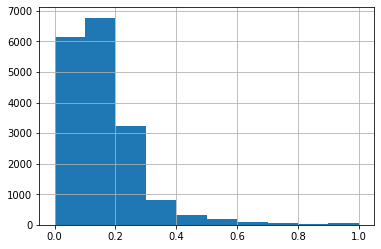

In [64]:
word = " man "
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.3f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when{}is present: {:.3f}".format(word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

proportion of responses that have this word: 0.003

 woman 
count   5260.000
mean       0.446
std        0.227
min        0.001
25%        0.270
50%        0.434
75%        0.599
max        1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.386

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when woman is present: 0.351
how often model gets it wrong overall: 0.178


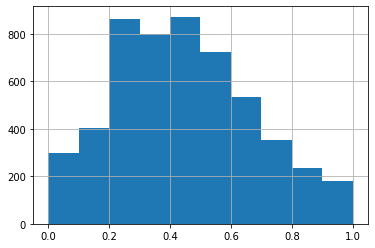

In [63]:
word = " woman "
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.3f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when{}is present: {:.3f}".format(word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

proportion of responses that have this word: 0.014

 love 
count   22249.000
mean        0.283
std         0.187
min         0.000
25%         0.167
50%         0.266
75%         0.365
max         1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.100

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when love is present: 0.199
how often model gets it wrong overall: 0.178


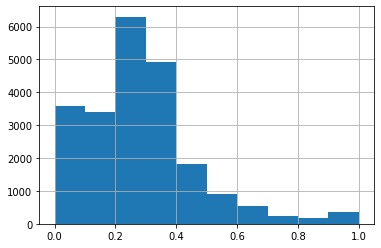

In [62]:
word = " love "
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.3f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when{}is present: {:.3f}".format(word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

proportion of responses that have this word: 0.002

 amazing 
count   3055.000
mean       0.297
std        0.195
min        0.000
25%        0.183
50%        0.269
75%        0.371
max        1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.127

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when amazing is present: 0.224
how often model gets it wrong overall: 0.178


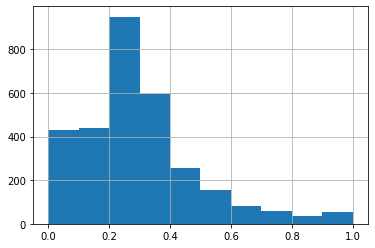

In [61]:
word = " amazing "
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.3f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when{}is present: {:.3f}".format(word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

proportion of responses that have this word: 0.004

 strong 
count   6886.000
mean       0.239
std        0.183
min        0.000
25%        0.134
50%        0.223
75%        0.299
max        1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.069

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when strong is present: 0.167
how often model gets it wrong overall: 0.178


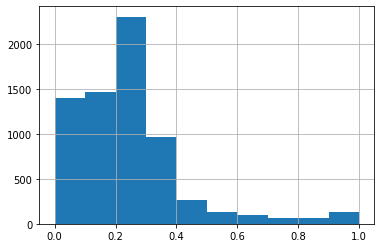

In [65]:
word = " strong "
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.3f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when{}is present: {:.3f}".format(word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

proportion of responses that have this word: 0.002

 planned parenthood 
count   2427.000
mean       0.363
std        0.171
min        0.000
25%        0.258
50%        0.359
75%        0.462
max        0.999
Name: probs, dtype: float64
proportion of responses where we predict W: 0.184

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when planned parenthood is present: 0.274
how often model gets it wrong overall: 0.178


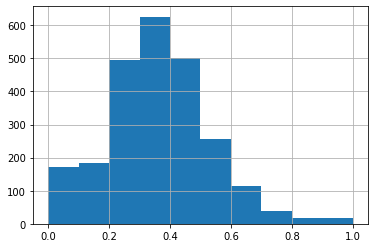

In [66]:
word = " planned parenthood "
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.3f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when{}is present: {:.3f}".format(word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

proportion of responses that have this word: 0.00004

 kamala 
count   68.000
mean     0.818
std      0.293
min      0.024
25%      0.816
50%      0.974
75%      0.993
max      1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.809

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when kamala is present: 0.721
how often model gets it wrong overall: 0.178


,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
494999,6412939,76094169,M,241643,Diane,"thank you, senator whitehouse! i am waiting to hear the same from my own senators, senator diane...",Sheldon Whitehouse,Congress_Democratic,0.024,M,1.000,Congress_Democratic
95845,2972496,42138413,M,80101,Frank,"do i trust these senators to do anything? no. republicans richard burr, north carolina, chairm...",Tim Scott,Congress_Republican,0.093,M,0.552,Congress_Democratic
800682,9177594,61839194,M,327362,Kala,"thank you, cory! i wrote to the white house today and also to kamala harris to lend my time and ...",Cory Booker,Congress_Democratic,0.137,M,0.543,Congress_Democratic
270464,3498555,33093506,W,114291,Rebecca,trump/russian hacking & senate investigation: http://www.chicagotribune.com/news/nationworld/ct...,Tammy Baldwin,Congress_Democratic,0.220,M,0.777,Congress_Democratic
1419573,13829819,8879946,M,541560,Linda,"actually, I had like to know more about the group that did the filming, and find out if they bro...",Bill Cassidy,Congress_Republican,0.231,M,0.176,Congress_Republican
802819,9179854,61839194,M,327362,Chris,corey - you think you are left? no you are not - you are a centrist with some left tendencies an...,Cory Booker,Congress_Democratic,0.239,M,0.393,Congress_Republican
824732,9203068,61839194,M,327383,Florencia,"senator booker, i think that for the same reason that you thought it harmless, essentially, to v...",Cory Booker,Congress_Democratic,0.244,M,0.568,Congress_Democratic
933751,9320885,61839194,M,327804,Lisa,"our homes are homes are being stolen #wallstcrime while our officials are taking selfies, i want...",Cory Booker,Congress_Democratic,0.247,M,0.554,Congress_Democratic
93969,2619057,19770004,W,64457,Tracey,"although those are good reasons to question the electoral vote, there is one other reason that h...",Barbara Lee,Congress_Democratic,0.267,M,0.358,Congress_Republican
100763,2977645,42138413,M,80109,Aaron,"america, democrats, republicans, independents, libertarians, green partiers, and others, remembe...",Tim Scott,Congress_Republican,0.294,M,0.357,Congress_Republican


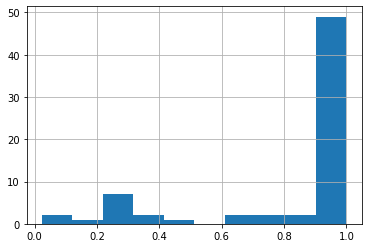

In [71]:
word = " kamala "
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.5f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when{}is present: {:.3f}".format(word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))
word_preds.sort_values('probs', ascending=True)[:20]

Interesting that congressman and congresswoman seem to be way better signals to the model of addressing a poster of a certain gender, compared to man vs woman

proportion of responses that have this word: 0.00907

 congressman 
count   14476.000
mean        0.056
std         0.108
min         0.000
25%         0.007
50%         0.017
75%         0.049
max         1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.011

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when congressman is present: 0.041
how often model gets it wrong overall: 0.178


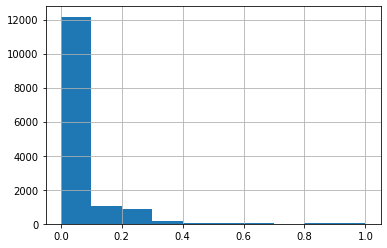

In [74]:
word = " congressman "
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.5f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when{}is present: {:.3f}".format(word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

proportion of responses that have this word: 0.00192

 congresswoman 
count   3057.000
mean       0.876
std        0.242
min        0.004
25%        0.914
50%        0.985
75%        0.998
max        1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.892

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when congresswoman is present: 0.106
how often model gets it wrong overall: 0.178


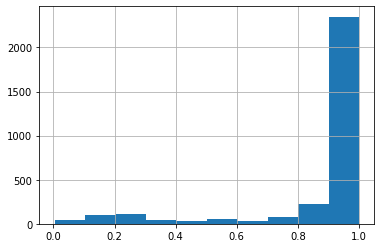

In [75]:
word = " congresswoman "
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.5f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when{}is present: {:.3f}".format(word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

proportion of responses that have this word: 0.00186

 mother 
count   2961.000
mean       0.298
std        0.153
min        0.000
25%        0.212
50%        0.288
75%        0.371
max        0.998
Name: probs, dtype: float64
proportion of responses where we predict W: 0.084

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when mother is present: 0.226
how often model gets it wrong overall: 0.178


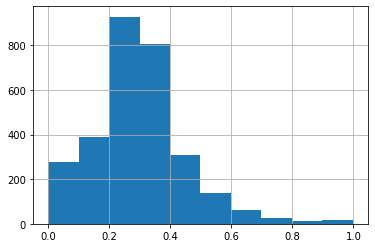

In [76]:
word = " mother "
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.5f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when{}is present: {:.3f}".format(word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

"Her": is intersting - model seems to have learned it as strong signal for female, but it's wrong a lot of the time. Way more than "his" is wrong. Same thing with "she"

proportion of responses that have this word: 0.01760

 her 
count   28094.000
mean        0.431
std         0.225
min         0.000
25%         0.264
50%         0.415
75%         0.569
max         1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.347

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when her is present: 0.356
how often model gets it wrong overall: 0.178


,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
933624,9320746,61839194,M,327804,Cee,i voted for kamala in the primary and will be voting for her again in november!,Cory Booker,Congress_Democratic,0.999,W,1.000,Congress_Democratic
861069,9241643,61839194,M,327395,Betty,you are standing with a newly elected representative of new hampshire. former governor maggie ha...,Cory Booker,Congress_Democratic,0.999,W,0.997,Congress_Democratic
933696,9320824,61839194,M,327804,Ellen,a friend of cory booker is a friend of mine though i cannot vote for her because i do not live i...,Cory Booker,Congress_Democratic,0.999,W,0.999,Congress_Democratic
516602,7079591,98302075,M,265965,Steven,jessica haha patty murray pretty much put her in her place!,Mark Pocan,Congress_Democratic,0.998,W,0.993,Congress_Democratic
933847,9320982,61839194,M,327804,Cathleen,thank you! I am a huge supporter of kamala harris and I am happy to see you supporting her. sh...,Cory Booker,Congress_Democratic,0.997,W,1.000,Congress_Democratic
467756,6366213,21956266,M,233488,Glenn,"ben, on this, let the people see and say what they think. how about you get behind mia love and ...",Ben Sasse,Congress_Republican,0.995,W,0.001,Congress_Republican
579908,7523458,65473098,M,288674,Marie,"i see that, true to her nature, lynn jenkins voted for it.",Thomas Massie,Congress_Republican,0.995,W,0.001,Congress_Republican
1228812,12344789,18759563,M,458996,Michelle,"daniel murray, I am glad you know so much about the congressman's personal life. maybe we need t...",Tom Cotton,Congress_Republican,0.995,W,0.938,Congress_Democratic
546318,7487646,65473098,M,288147,Searching,gabbard is one of very few democrats i respect even if i do not fully agree with her stances,Thomas Massie,Congress_Republican,0.994,W,0.974,Congress_Democratic
36731,2004506,60229427,M,31116,Barb,"i sent the letter & got the response i expected.basically patty thinks it is wonderful.wow, i se...",John Thune,Congress_Republican,0.994,W,0.988,Congress_Democratic


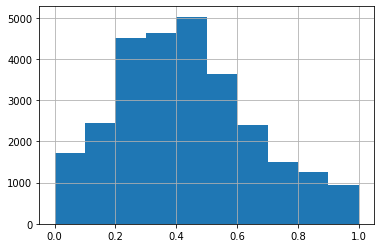

In [91]:
word = " her "
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.5f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when{}is present: {:.3f}".format(word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))
word_wrong_preds.sort_values('probs', ascending=False)[:20]

proportion of responses that have this word: 0.04206

 his 
count   67129.000
mean        0.182
std         0.114
min         0.000
25%         0.123
50%         0.170
75%         0.221
max         1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.020

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when his is present: 0.135
how often model gets it wrong overall: 0.178


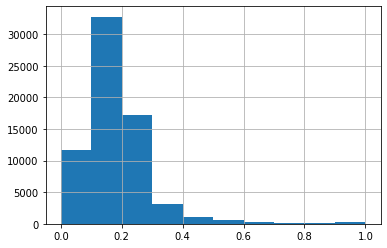

In [87]:
word = " his "
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.5f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when{}is present: {:.3f}".format(word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))

proportion of responses that have this word: 0.01938

 she 
count   30940.000
mean        0.445
std         0.220
min         0.000
25%         0.281
50%         0.441
75%         0.580
max         1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.384

overall
count   1438596.000
mean          0.243
std           0.144
min           0.000
25%           0.171
50%           0.234
75%           0.296
max           1.000
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when she is present: 0.370
how often model gets it wrong overall: 0.178


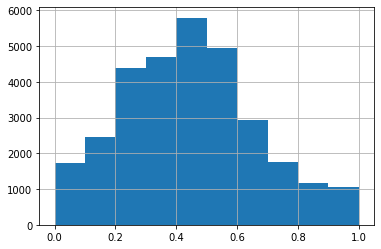

In [92]:
word = " she "
word_preds = test_df[test_df['response_text'].str.contains(word)]
word_preds.probs.hist()
print("proportion of responses that have this word: {:.5f}".format(word_preds.shape[0] / test_preds.shape[0]))
print("\n{}".format(word))
print(word_preds.probs.describe())
print("proportion of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
print("\noverall")
print(test_df.probs.describe())
word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
print("\nhow often model gets it wrong when{}is present: {:.3f}".format(word, word_wrong_preds.shape[0] / word_preds.shape[0]))
print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))